In [1]:
import os
from dotenv import load_dotenv, find_dotenv
import warnings

_ = load_dotenv(find_dotenv())
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display, Markdown

## Importing an LLM

In [3]:
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.mistral import MistralChatGenerator
model = "mistral-large-latest"

client = MistralChatGenerator(model=model)

/opt/anaconda3/envs/llamaindex/lib/python3.12/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


## Chatting wiith an LLM

Option 1: Using `run`

In [4]:
response = client.run(
    messages=[ChatMessage.from_user("What is the capital of France?")]
)

In [5]:
response

{'replies': [ChatMessage(content="The capital of France is Paris. Known for its art, culture, cuisine, and fashion, Paris is also the most populous city in France. It is home to iconic landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. Paris has been the capital since 508 AD, and it is the seat of the French government and the country's political, economic, and cultural center.", role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'mistral-large-latest', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 96, 'prompt_tokens': 10, 'total_tokens': 106, 'completion_tokens_details': None}})]}

Notice that the result of a run is a dictionary with a list of chat messages!

In [6]:
display(Markdown(response['replies'][-1].content))

The capital of France is Paris. Known for its art, culture, cuisine, and fashion, Paris is also the most populous city in France. It is home to iconic landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. Paris has been the capital since 508 AD, and it is the seat of the French government and the country's political, economic, and cultural center.

Option 2: Using streaming responses
> You'll need to pass a callback into a chat generator function

In [7]:
from haystack.components.generators.utils import print_streaming_chunk
from haystack_integrations.components.generators.mistral import MistralChatGenerator

In [8]:
## Redefine our client
streaming_client = MistralChatGenerator(
    model=model,
    streaming_callback=print_streaming_chunk
)

In [9]:
response = streaming_client.run(
    messages=[ChatMessage.from_user("What is the capital of France?")]
)

The capital of France is Paris. Known for its art, culture, cuisine, and fashion, Paris is also the most populous city in France. It is home to iconic landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. Paris has been the capital since 508 AD, and it is the seat of the French government and the country's political, economic, and cultural center.

And there we have it! The client streams replies!

In [10]:
response

{'replies': [ChatMessage(content="The capital of France is Paris. Known for its art, culture, cuisine, and fashion, Paris is also the most populous city in France. It is home to iconic landmarks such as the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. Paris has been the capital since 508 AD, and it is the seat of the French government and the country's political, economic, and cultural center.", role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'mistral-large-latest', 'index': 0, 'finish_reason': 'stop', 'usage': {}})]}

And when you look at what response is again, it is still a dictionary! So the only difference between the streaming and non-streaming approach is that chunks get printed out in the display for the streaming approach!

#### Chat history
Just create a list and append messages!

In [11]:
from typing import List

chat_history: List[ChatMessage] = []

In [12]:
## Append user question
chat_history.append(
    ChatMessage.from_user("Hi! My name is Titus. What is the capital of France?")
)

## Run chat
response = client.run(
    messages=chat_history
)
print(response['replies'][-1].content)

## Append LLM's answer
chat_history.append(
    ChatMessage.from_assistant(response['replies'][-1].content)
)

## Append next question
chat_history.append(
    ChatMessage.from_user("What's my name again?")
)

## Run next question
response = client.run(
    messages=chat_history
)
print("\n\n")
print(response['replies'][-1].content)

Hello Titus! The capital of France is Paris. It's known for iconic landmarks like the Eiffel Tower, the Louvre Museum, and Notre-Dame Cathedral. It's also a global center for art, fashion, gastronomy, and culture.



Your name is Titus, as you introduced yourself earlier. It's a pleasure to assist you! If you have any more questions or need further assistance, feel free to ask.


## Structured Prediction
Pipeline abstractions and jinja style prompting are core to Haystack's library and are central to most haystack applications (except for chat). Let's see how we can use pipelines for structured prediction

In [13]:
from pydantic import BaseModel
from typing import List

class Exercise(BaseModel):
    """Generates a workout plan given a focus area"""
    exercise: str
    number_of_reps: int
    number_of_sets: int

class WorkoutPlan(BaseModel):
    exercises: List[Exercise]

After defining the schema of the output we are hoping for, we need to generate JSON schema to instruct the LLM later in the prompt.

In [14]:
json_schema = WorkoutPlan.schema_json(indent=2)

In [15]:
display(Markdown(json_schema))

{
  "$defs": {
    "Exercise": {
      "description": "Generates a workout plan given a focus area",
      "properties": {
        "exercise": {
          "title": "Exercise",
          "type": "string"
        },
        "number_of_reps": {
          "title": "Number Of Reps",
          "type": "integer"
        },
        "number_of_sets": {
          "title": "Number Of Sets",
          "type": "integer"
        }
      },
      "required": [
        "exercise",
        "number_of_reps",
        "number_of_sets"
      ],
      "title": "Exercise",
      "type": "object"
    }
  },
  "properties": {
    "exercises": {
      "items": {
        "$ref": "#/$defs/Exercise"
      },
      "title": "Exercises",
      "type": "array"
    }
  },
  "required": [
    "exercises"
  ],
  "title": "WorkoutPlan",
  "type": "object"
}

Create a custom output validator to validate the generated response against the provided pydantic output. If there's an error, we'll loop to get the llm to generate another response.
> source: https://haystack.deepset.ai/tutorials/28_structured_output_with_loop

In [16]:
import json
import random
from pydantic import ValidationError
from typing import Optional, List
from colorama import Fore
from haystack import component

## Adding the class with a `component` decorator allows this to be called as
## a pipeline component

@component
class OutputValidator:
    def __init__(self, pydantic_model: BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0
    
    ## Define component output
    @component.output_types(
        valid_replies = List[str], 
        invalid_replies = Optional[List[str]],
        error_message = Optional[str],
    )
    def run(self, replies: List[str]):
        """Method to run the class component"""
        
        self.iteration_counter += 1
        
        ## Parse LLM reply
        try:
            output_dict = json.loads(replies[0])
            self.pydantic_model.parse_obj(output_dict)
            print(
                Fore.GREEN
                + f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies}
        
        except (ValueError, ValidationError) as e:
            print(
                Fore.RED
                + f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}

In [17]:
output_validator = OutputValidator(pydantic_model=WorkoutPlan)

#### Creating the prompt
Jinja style

In [18]:
from haystack.components.builders import PromptBuilder

prompt_template = """
Create a workout plan from the user's question: {{question}}.
Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""
prompt_builder = PromptBuilder(template=prompt_template)

Yup you saw it correctly. The {% %} if-else statement is jinja! 

#### Building the pipeline
There's an unpleasant surprise here. You can only use llms in Haystack that have the `generator` abstraction defined and not the `chatgenerator` abstraction. That's because the `chatgenerator` abstraction accepts a list of chat messages. So we'll have to use a different llm here because Haystack does not have a `MistralAIGenerator` abstraction.

> I've also tried using `GoogleAIGeminiGenerator` and it yielded an error. So there needs to be some trial and error here. Haystack's integration of other llms aren't consistent.

In [19]:
from haystack.components.generators import OpenAIGenerator

generator = OpenAIGenerator(model="gpt-4o-mini")

In [20]:
from haystack import Pipeline

pipeline = Pipeline(max_runs_per_component=5) #don't let the llm go crazy

# Add components to your pipeline. These are the nodes in the graph.
pipeline.add_component(instance=prompt_builder, name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=output_validator, name="output_validator")


Now we connect the components. We connect the prompt_builder to the llm which means that we first populate the placeholder in the prompt with our question, and send the full prompt to the llm.

The llm component is connected to the output validator. This means that the outputs of the llm are sent to the validator for validation.
- If the outcome of the validation is an invalid reply or an error message, it's sent to the prompt_builder again.
- Otherwise if everything passes, the output validator returns the result!

In [21]:
# Now, connect the components to each other. These are the edges in the graph.
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")

# If a component has more than one output or input, we need to explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

Assuming you have no error messages. You can visualize the pipeline using a very neat utility

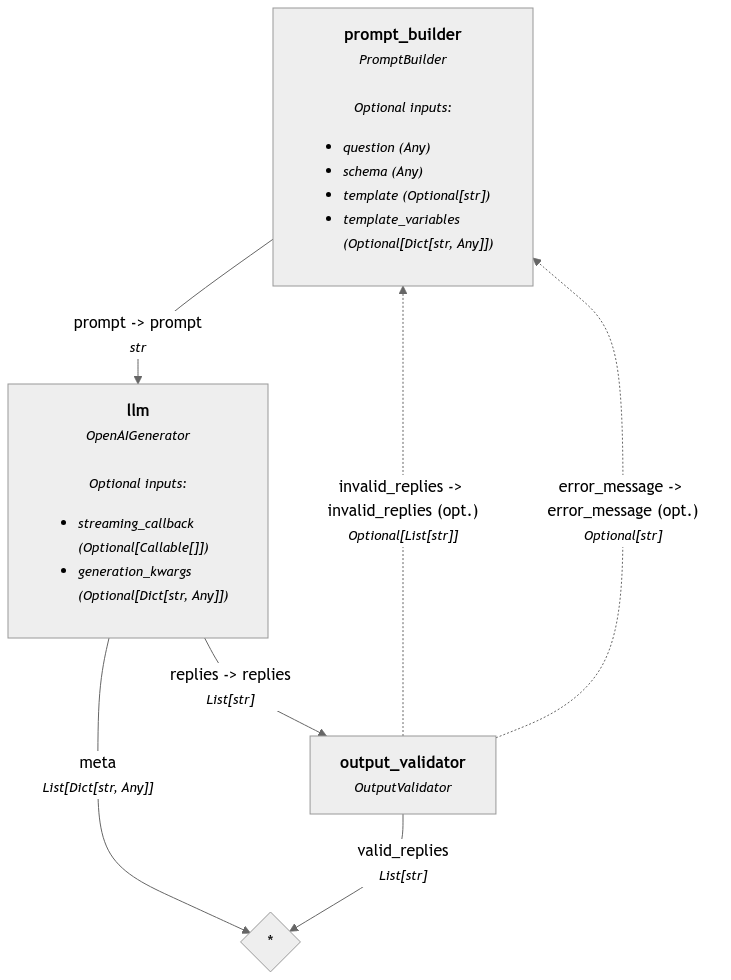

In [22]:
pipeline.show()

You could also save the pipeline file as an image.

In [23]:
pipeline.draw("workout_plan.png")

## Testing the pipeline
The inputs to the pipeline is a nested dictionary with the key-value pair inputs for the prompt_builder. Of course if your pipeline is more complicated, you'll have more complicated input-output pairs.

In [24]:
question="Generate a workout plan for biceps"
result = pipeline.run(
    {"prompt_builder": {
        "question": question, 
        "schema": json_schema}
    }
)

OutputValidator at Iteration 1: Valid JSON from LLM - No need for looping: {
  "exercises": [
    {
      "exercise": "Bicep Curls",
      "number_of_reps": 12,
      "number_of_sets": 3
    },
    {
      "exercise": "Hammer Curls",
      "number_of_reps": 10,
      "number_of_sets": 3
    },
    {
      "exercise": "Concentration Curls",
      "number_of_reps": 12,
      "number_of_sets": 3
    },
    {
      "exercise": "Barbell Curls",
      "number_of_reps": 10,
      "number_of_sets": 3
    },
    {
      "exercise": "Preacher Curls",
      "number_of_reps": 8,
      "number_of_sets": 3
    }
  ]
}


And that's the exercise plan for biceps. We can also print the results after using the `json.loads` method

In [25]:
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

{'exercises': [{'exercise': 'Bicep Curls', 'number_of_reps': 12, 'number_of_sets': 3}, {'exercise': 'Hammer Curls', 'number_of_reps': 10, 'number_of_sets': 3}, {'exercise': 'Concentration Curls', 'number_of_reps': 12, 'number_of_sets': 3}, {'exercise': 'Barbell Curls', 'number_of_reps': 10, 'number_of_sets': 3}, {'exercise': 'Preacher Curls', 'number_of_reps': 8, 'number_of_sets': 3}]}


## Zero shot classification!
We'll use the same output validator coded earlier

In [26]:
from typing import Literal

class DocumentFolder(BaseModel):
    """Returns only one output folder name given a document name"""
    
    folder_name: Literal[
        "finance",
        "presentations",
        "sketchbook",
        "code"
    ]

In [27]:
folder_sorter_schema = DocumentFolder.schema_json(indent=2)

In [28]:
display(Markdown(folder_sorter_schema))

{
  "description": "Returns only one output folder name given a document name",
  "properties": {
    "folder_name": {
      "enum": [
        "finance",
        "presentations",
        "sketchbook",
        "code"
      ],
      "title": "Folder Name",
      "type": "string"
    }
  },
  "required": [
    "folder_name"
  ],
  "title": "DocumentFolder",
  "type": "object"
}

We'll have to edit the prompt template a little

In [29]:
file_sorter_prompt_template = """
Return the most appropriate folder to store the user's file from the
user's question: {{question}}.
Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""
file_sorter_prompt_builder = PromptBuilder(template=file_sorter_prompt_template)

In [30]:
folder_sorter_pipeline = Pipeline(max_runs_per_component=5) #don't let the llm go crazy

# Add components to your pipeline. These are the nodes in the graph.
folder_sorter_pipeline.add_component(instance=file_sorter_prompt_builder, name="prompt_builder")
folder_sorter_pipeline.add_component(instance=generator, name="llm")

PipelineError: Component has already been added in another Pipeline. Components can't be shared between Pipelines. Create a new instance instead.

Wait what's wrong here? Haystack does some checking on whether components are shared pipelines in the background. This is just a layer of error checking that can be helpful. So we'll have to define a new instance of all the components.

In [35]:
generator_v2 = OpenAIGenerator(model="gpt-4o-mini")
output_validator_v2 = OutputValidator(pydantic_model=DocumentFolder)

In [36]:
file_sorter_prompt_builder_v2 = PromptBuilder(template=file_sorter_prompt_template)

In [37]:
folder_sorter_pipeline_v2 = Pipeline(max_runs_per_component=5)

folder_sorter_pipeline_v2.add_component(instance=file_sorter_prompt_builder_v2, name="prompt_builder")
folder_sorter_pipeline_v2.add_component(instance=generator_v2, name="llm")
folder_sorter_pipeline_v2.add_component(instance=output_validator_v2, name="output_validator")

In [38]:
# Now, connect the components to each other. These are the edges in the graph.
folder_sorter_pipeline_v2.connect("prompt_builder", "llm")
folder_sorter_pipeline_v2.connect("llm", "output_validator")

# If a component has more than one output or input, we need to explicitly specify the connections:
folder_sorter_pipeline_v2.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
folder_sorter_pipeline_v2.connect("output_validator.error_message", "prompt_builder.error_message")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

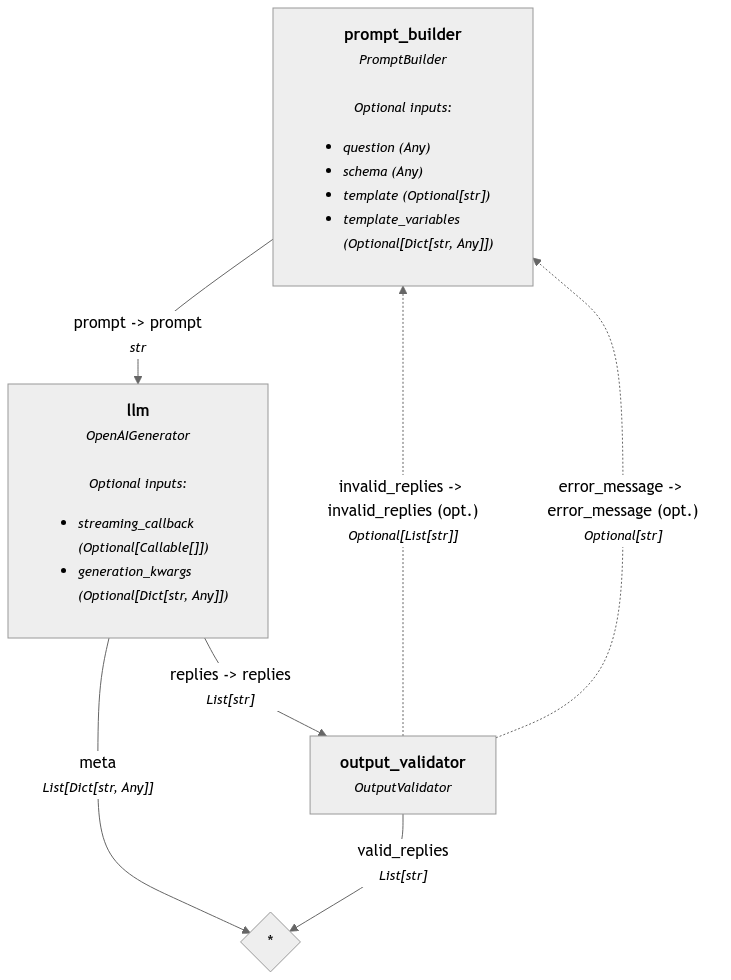

In [40]:
folder_sorter_pipeline_v2.show()

In [42]:
question="Where should I store the file 'llama_sketch.png'?"
result = folder_sorter_pipeline_v2.run(
    {"prompt_builder": {
        "question": question, 
        "schema": folder_sorter_schema}
    }
)

OutputValidator at Iteration 1: Valid JSON from LLM - No need for looping: {
  "folder_name": "sketchbook"
}


In [44]:
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

{'folder_name': 'sketchbook'}


Done!

> Note: This isn't an 'official' way to do routing in Haystack. 
> - One of the official ways uses a Transformer on a GPU. See https://docs.haystack.deepset.ai/v1.25/docs/query_classifier

The other official way is to add conditional routing to your pipeline!
> This way still uses the jinja method in your string. So you will have to know some basic jinja syntax.

In [45]:
from haystack.components.routers import ConditionalRouter

In [48]:
routes = [
    {
        "condition": "{{'presentation' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "presentation",
        "output_type": str,
    },
    {
        "condition": "{{'coding' in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "coding",
        "output_type": str,
    },
]

In [49]:
router = ConditionalRouter(routes=routes)

Let's say we have a reply. This is how we do it

In [50]:
router.run(replies=['coding'], query="Where should I store abc.py?")

{'coding': 'coding'}

Well great. Now we have to connect this to our pipeline which you'll have to define. OK moving on!

In [51]:
prompt_for_routing = """
Answer the following query with either 'presentation' or 'coding'.
The user is only seeking for your opinion on the folder to save their
file of interest in the query.

Query: {{query}}
"""

In [52]:
prompt_builder_for_routing = PromptBuilder(prompt_for_routing)

In [53]:
router_pipe = Pipeline()
router_pipe.add_component(
    "prompt_builder", prompt_builder_for_routing
)
router_pipe.add_component(
    "llm", OpenAIGenerator(model="gpt-4o-mini")
)
router_pipe.add_component(
    "router", router
)

router_pipe.connect("prompt_builder", "llm")
router_pipe.connect("llm", "router")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - router: ConditionalRouter
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])

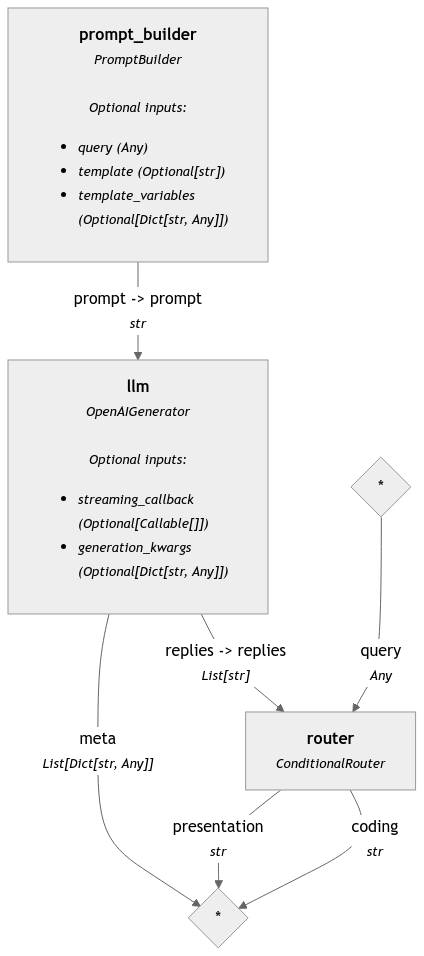

In [54]:
router_pipe.show()

In [55]:
query = "Where should I keep this file: abc.py?"
router_pipe.run(
    {"prompt_builder": {"query": query},
     "router": {"query": query}
    }
)

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 1,
     'prompt_tokens': 55,
     'total_tokens': 56,
     'completion_tokens_details': CompletionTokensDetails(reasoning_tokens=0),
     'prompt_tokens_details': {'cached_tokens': 0}}}]},
 'router': {'coding': 'coding'}}

There you go. Under 'router' we see that the answer is 'coding'.

## Calling tools
I have to say straight up then I am not a fan of the way Haystack does its tool calling. Unlike the pipeline approach, this is done by chat generator models instead of generator models. You would think that we can use Mistral to do this again but Mistral's tool calling capabilities were not coded in Haystack. So we'll stick with OpenAI

There are two ways of doing this. 

The first is by representing the function in json format. This is similar to the way you would invoke a function in OpenAI, and other llm providers. I'm not a fan of this because an orchestration library's main purpose is to make it easier for you to interact with different llm libraries. 
> This portion is directly lifted from: https://docs.haystack.deepset.ai/docs/function-calling

In [59]:
## Define a weather tool

tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "format": {
                        "type": "string",
                        "enum": ["celsius", "fahrenheit"],
                        "description": "The temperature unit to use. Infer this from the users location.",
                    },
                },
                "required": ["location", "format"],
            },
        }
    }
]

So what's "the weather tool"? It's a function that returns the weather given a city and state. This may not be so easy to see but all the llm providers understand this well.

In [62]:
messages = [ChatMessage.from_user("What's the weather like in Berlin?")]
response = client.run(messages=messages, generation_kwargs= {"tools": tools})
response_msg = response["replies"][0]

In [63]:
messages.append(response_msg)
print(response_msg)

ChatMessage(content='[{"id": "VhPmtlGoL", "function": {"arguments": "{\\"location\\": \\"Berlin, Germany\\", \\"format\\": \\"celsius\\"}", "name": "get_current_weather"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'mistral-large-latest', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 35, 'prompt_tokens': 135, 'total_tokens': 170, 'completion_tokens_details': None}})


Wait... The llm only selected the function but didn't invoke the tool! You're still going to have to invoke it separately and append the results to the list of message strings and send everything to the chatgenerator all over again

Haystack's experimental library has a different way of doing this but is still in the experimental stage.
> https://haystack.deepset.ai/cookbook/tools_support

## RAG

Like LlamaIndex, Haystack does not require you to provide any vector database clients. You can just call an InMemory Document Store

In [84]:
from haystack.components.embedders import OpenAIDocumentEmbedder

embedder_model = OpenAIDocumentEmbedder(model="text-embedding-3-small")

First you'll have to create the ingestion pipeline
> Note I tried this using Mistral embeddings but there was a problem connecting the splitter with the embedder due to output typing.

In [85]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
text_file_converter = TextFileToDocument()
document_splitter = DocumentSplitter()
document_writer = DocumentWriter(document_store=document_store)

In [86]:
ingestion = Pipeline()
ingestion.add_component("converter", text_file_converter)
ingestion.add_component("splitter", document_splitter)
ingestion.add_component("embedder", embedder_model)
ingestion.add_component("writer", document_writer)

In [87]:
ingestion.connect("converter", "splitter")
ingestion.connect("splitter", "embedder")
ingestion.connect("embedder", "writer")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

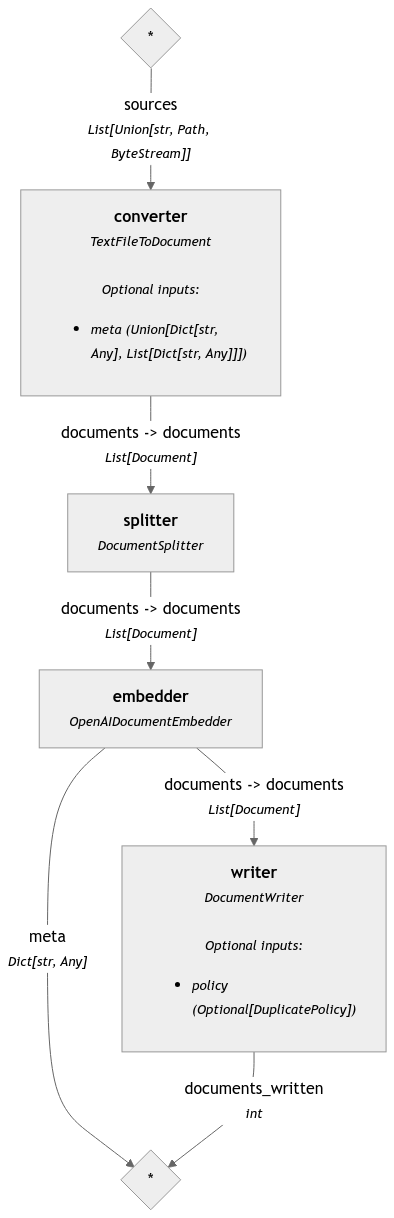

In [88]:
ingestion.show()

Run it

In [89]:
ingestion.run({"converter": {"sources": ['../../data/paul_graham/paul_graham_essay.txt']}})

Calculating embeddings: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


{'embedder': {'meta': {'model': 'text-embedding-3-small',
   'usage': {'prompt_tokens': 16775, 'total_tokens': 16775}}},
 'writer': {'documents_written': 69}}

And now our in-memory document store is populated. We can look at any of the content we want

In [92]:
document_store.filter_documents()[2].content

"was sold as a kit by Heathkit. I remember vividly how impressed and envious I felt watching him sitting in front of it, typing programs right into the computer.\n\nComputers were expensive in those days and it took me years of nagging before I convinced my father to buy one, a TRS-80, in about 1980. The gold standard then was the Apple II, but a TRS-80 was good enough. This was when I really started programming. I wrote simple games, a program to predict how high my model rockets would fly, and a word processor that my father used to write at least one book. There was only room in memory for about 2 pages of text, so he'd write 2 pages at a time and then print them out, but it was a lot better than a typewriter.\n\nThough I liked programming, I didn't plan to study it in college. In college I was going to study philosophy, which sounded much more powerful. It seemed, to my naive high school self, to be the study of the ultimate truths, compared to which the things studied in other fie

#### Create a RAG Pipeline

In [95]:
rag_prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""
rag_prompt_builder = PromptBuilder(template=rag_prompt)

We have to use OpenAITextEmbedder in this case to ensure dimensionality match when we embed the user queries

In [97]:
from haystack.components.embedders import OpenAITextEmbedder #To embed the user's query
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

query_embedder_model = OpenAITextEmbedder()
document_retriever = InMemoryEmbeddingRetriever(document_store=document_store)
answer_generator = OpenAIGenerator()

rag = Pipeline()
rag.add_component("query_embedder", query_embedder_model)
rag.add_component("retriever", document_retriever)
rag.add_component("prompt", rag_prompt_builder)
rag.add_component("generator", answer_generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

In [98]:
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

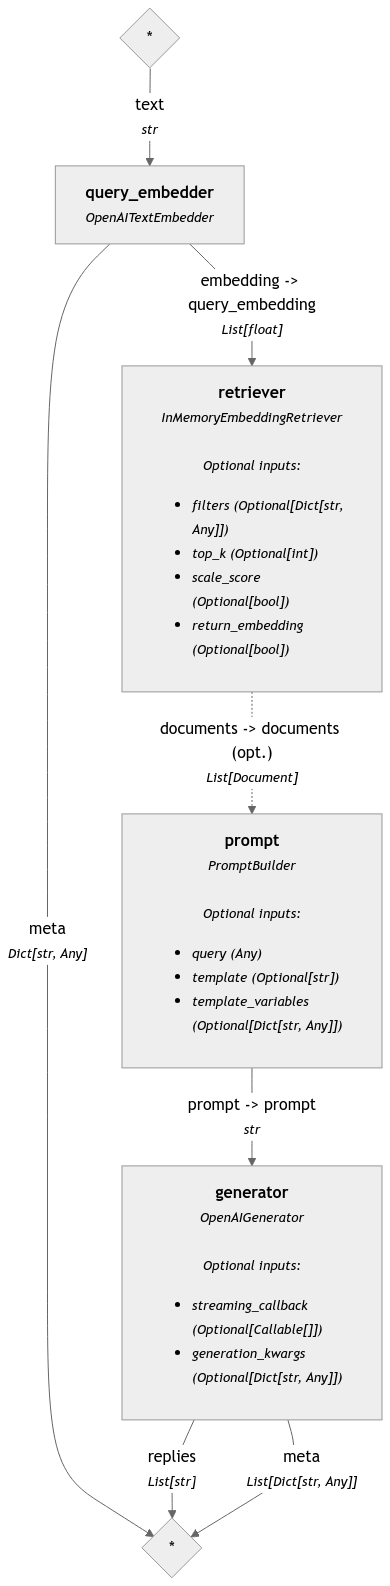

In [99]:
rag.show()

In [101]:
question = "Did Paul Graham write code??"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

The provided context does not explicitly mention whether Paul Graham wrote code. It focuses on the development of the Y Combinator batch model and their approach to funding startups. Therefore, based on the information given, we cannot determine if Paul Graham wrote code.


Hmm this is wrong. And we know this because Langchain and LlamaIndex's rag returned the correct answer. This means that the base Haystack retriever might not be a good one.